---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sodapy import Socrata

pd.set_option('future.no_silent_downcasting', True)

In [24]:
# Read in excel data
all_sheets = pd.read_excel('../../data/raw-data/202223-hs-sqr-results.xlsx', skiprows=3, nrows=506, sheet_name=None)

In [25]:
# Concat 4 dicts of sheets
df = pd.concat(all_sheets.values(), axis=1)

In [26]:
# pre cleaning df.head check
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,...,N Count - % of students who took the US History Regents in the current year who scored 65+,Metric Value - % of students who took the US History Regents in the current year who scored 65+,N Count - % of students who took the Algebra I Regents exam in the current year who scored 65+,Metric Value - % of students who took the Algebra I Regents exam in the current year who scored 65+,N Count - % of students who took the Living Environment Regents in the current year who scored 65+,Metric Value - % of students who took the Living Environment Regents in the current year who scored 65+,N Count - % of students who took a Languages Other Than English Regents in the current year who scored 65+,Metric Value - % of students who took a Languages Other Than English Regents in the current year who scored 65+,N Count - % of students who took the Physics Regents in the current year who scored 65+,Metric Value - % of students who took the Physics Regents in the current year who scored 65+
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,01M292,Orchard Collegiate Academy,High School,269.0,Meeting Target,Exceeding Target,Meeting Target,...,49.0,0.612,51.0,0.451,52.0,0.615,32.0,0.969,1.0,N<15
2,NaN,NaN,NaN,01M448,University Neighborhood High School,High School,485.0,Exceeding Target,Exceeding Target,Exceeding Target,...,108.0,0.648,79.0,0.772,82.0,0.744,66.0,0.773,4.0,N<15
3,NaN,NaN,NaN,01M450,East Side Community School,High School,389.0,Exceeding Target,Exceeding Target,Exceeding Target,...,1.0,N<15,1.0,N<15,1.0,N<15,NaN,N<15,NaN,N<15
4,NaN,NaN,NaN,01M539,"New Explorations into Science, Technology and ...",High School,620.0,Meeting Target,Meeting Target,Exceeding Target,...,94.0,0.894,45.0,0.889,46.0,0.957,100.0,0.87,121.0,0.595


In [27]:
#Pre Cleaning data types
df.dtypes.value_counts()

float64    346
object     317
Name: count, dtype: int64

In [28]:
#make N<15 NA
df = df.replace('N<15', np.nan).infer_objects(copy=False)
df = df.replace('N<5', np.nan).infer_objects(copy=False)
#make values '<95%' as max 95%
df = df.replace('> 95%', int(0.95)).infer_objects(copy=False)

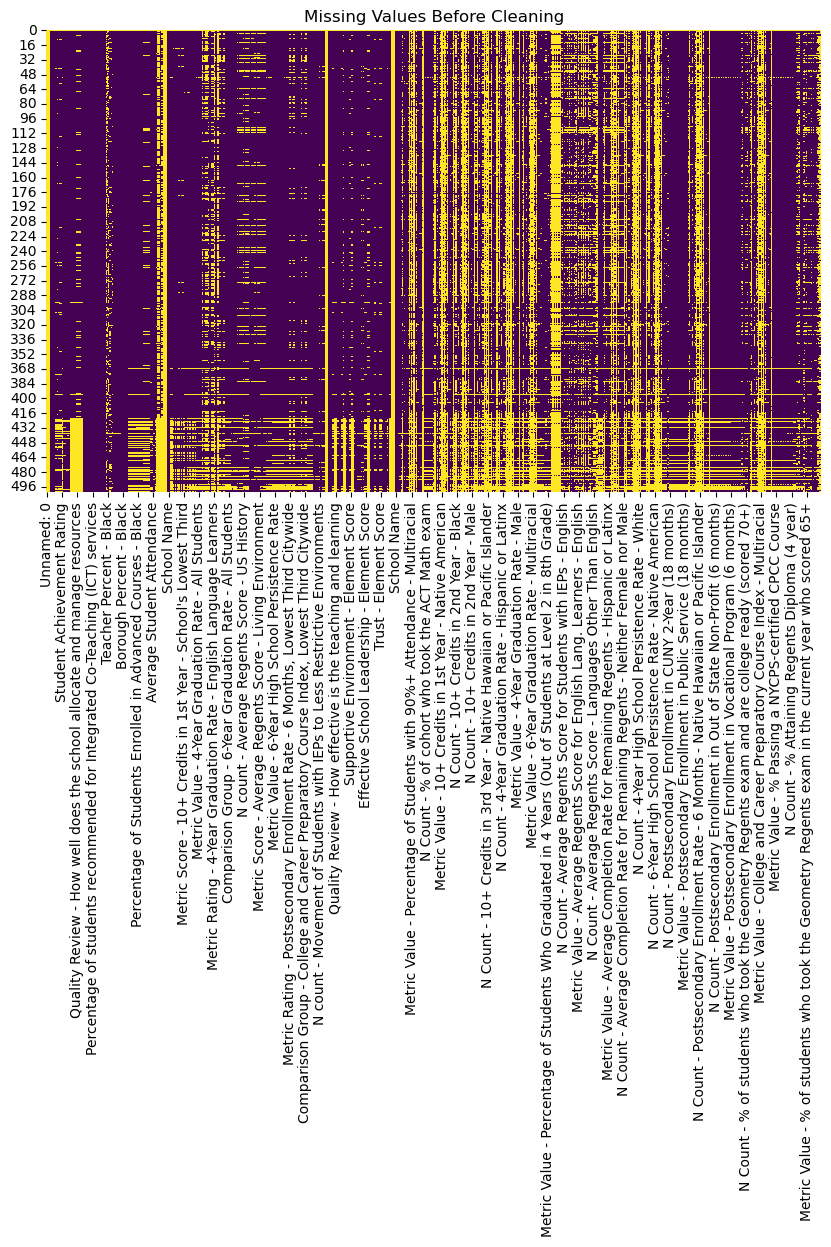

In [29]:
# Pre Cleaning Missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Before Cleaning")
plt.show()

In [30]:
#Handle Missingess

#remove columns that are missing > 50%
missingness = df.isna().mean()

# Filter columns with less than 75% missing values
df = df.loc[:, missingness < 0.5]

In [31]:
#columns to remove by string
#Unnamed: remove NA columns
#N count / metric rating / metric score / comparison group: we just need metric value % columns, these give the same info
#positive responses: remove borough and city positive response columns - we just need element score for these metrics
string_check = "Unnamed|N count|metric rating|metric score|comparison group|positive responses"

df = df.loc[:, ~df.columns.str.contains(string_check, regex=True, case=False)]

In [32]:
#drop duplicated columns
df = df.loc[:, ~df.T.duplicated(keep='first')]
#drop principal name, date of review, and School Type (they are all High Schools) columns
df = df.drop(columns=['Quality Review - Principal at Time of Review','School Type','Quality Review - Dates of Review'], axis=1)
#drop these columns with survey response questions, we have score columns for this
df = df.drop(columns=['Rigorous Instruction Rating','Collaborative Teachers Rating','Supportive Environment Rating','Effective School Leadership Rating','Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating'], axis=1)
#remove first row
df = df.iloc[1: , :]

In [33]:
#use ordinal encoder to encode categorical quality review columns

# get columns with 'proficient' categories
proficient_cols = [col for col in df.columns if df[col].astype(str).str.contains('proficient', case=False).any()]
proficient_hierarchy = ['Developing', 'Well Developed', 'Proficient']
encoder = OrdinalEncoder(categories=[proficient_hierarchy] * len(proficient_cols), handle_unknown='use_encoded_value', unknown_value=-1)

#run encoder
df[proficient_cols] = encoder.fit_transform(df[proficient_cols])

In [34]:
#extract District and Borough from DBN column - DBN: (##(District)X(Borough)###(School ID))
df = df.copy()
df['District'] = df['DBN'].str[0:2]
df['Borough'] = df['DBN'].str[2:3]

In [35]:
#map borough name to value
borough_map = {'M': 'Manhattan', 'K': 'Brooklyn', 'X': 'Bronx', 'Q':'Queens', 'R':'Staten Island'}
df['Borough'] = df['Borough'].map(borough_map) 

In [36]:
#handle data types

# #convert rate % to float
df['Student Survey Response Rate'] = pd.to_numeric(df['Student Survey Response Rate'].str[:-1]) / 100
df['Teacher Survey Response Rate'] = pd.to_numeric(df['Teacher Survey Response Rate'].str[:-1]) / 100
df['Parent Survey Response Rate'] = pd.to_numeric(df['Parent Survey Response Rate'].str[:-1]) / 100

#convert all metric value columns to numeric
df.loc[:, df.columns.str.contains('Metric Value')] = df.loc[:, df.columns.str.contains('Metric Value')].apply(pd.to_numeric, errors='coerce')

#convert remaining columns
df['Metric Value - 4-Year Graduation Rate - Special Class, Integrated Co-Teaching, or SETSS'] = pd.to_numeric(df['Metric Value - 4-Year Graduation Rate - Special Class, Integrated Co-Teaching, or SETSS'])
df['Metric Value - 4-Year Graduation Rate - English Language Learners'] = pd.to_numeric(df['Metric Value - 4-Year Graduation Rate - English Language Learners'])

In [37]:
#Post cleaning data check

df.dtypes.value_counts()

float64    224
object       4
Name: count, dtype: int64

In [38]:
#check remaining objects - keep these for EDA
df.select_dtypes(include=['object']).columns

Index(['DBN', 'School Name', 'District', 'Borough'], dtype='object')

In [39]:
#save processed df to csv
df.to_csv('../../data/processed-data/processed_df.csv')

In [40]:
# post cleaning df.head check
df.head()

,DBN,School Name,Enrollment,Rigorous Instruction - Percent Positive,Collaborative Teachers - Percent Positive,Supportive Environment - Percent Positive,Effective School Leadership - Percent Positive,Strong Family-Community Ties - Percent Positive,Trust - Percent Positive,Quality Review - How interesting and challenging is the curriculum,...,Metric Value - % of students who took the Chemistry Regents in the current year who scored 65+,Metric Value - % of students who took the English Regents exam in the current year who scored 65+,Metric Value - % of students who took the Earth Science Regents in the current year who scored 65+,Metric Value - % of students who took the Geometry Regents exam in the current year who scored 65+,Metric Value - % of students who took the Global History Regents in the current year who scored 65+,Metric Value - % of students who took the US History Regents in the current year who scored 65+,Metric Value - % of students who took the Algebra I Regents exam in the current year who scored 65+,Metric Value - % of students who took the Living Environment Regents in the current year who scored 65+,District,Borough
1,01M292,Orchard Collegiate Academy,269.0,0.73,0.88,0.80,0.87,0.81,0.90,2.0,...,0.524,0.770,0.622,0.556,0.783,0.612,0.451,0.615,01,Manhattan
2,01M448,University Neighborhood High School,485.0,0.83,0.93,0.86,0.94,0.85,0.95,1.0,...,0.355,0.747,0.752,0.667,0.759,0.648,0.772,0.744,01,Manhattan
3,01M450,East Side Community School,389.0,0.82,0.89,0.81,0.89,0.92,0.92,1.0,...,NaN,0.908,NaN,NaN,NaN,NaN,NaN,NaN,01,Manhattan
4,01M539,"New Explorations into Science, Technology and ...",620.0,0.80,0.85,0.78,0.82,0.93,0.90,1.0,...,0.842,0.975,NaN,0.895,1.000,0.894,0.889,0.957,01,Manhattan
5,01M696,Bard High School Early College,565.0,0.79,0.78,0.77,0.80,0.87,0.90,1.0,...,0.521,0.927,NaN,NaN,0.871,0.925,0.667,NaN,01,Manhattan


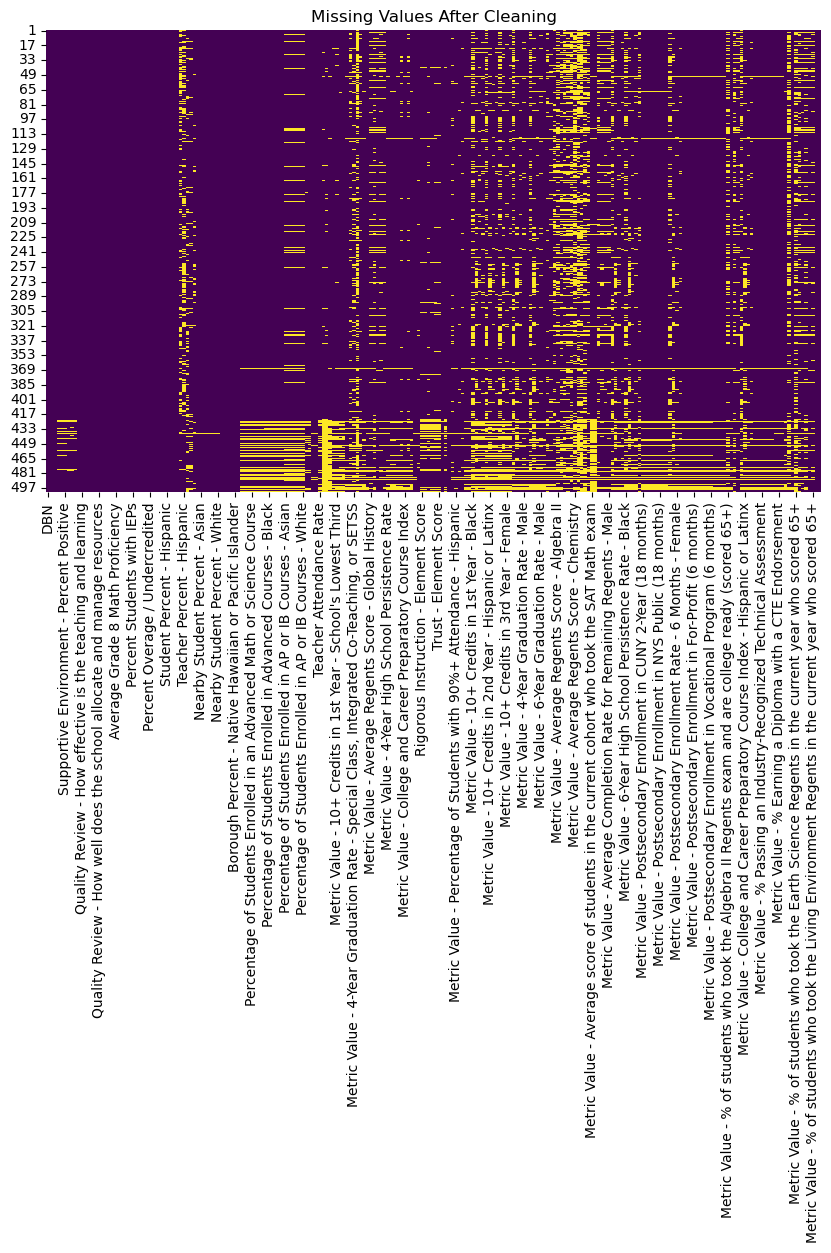

In [41]:
# post cleaning missingness check
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()